#Comparing Various Models for Multi-Class Classification for NLP Based Task

###Author - Harsh Sharma


#Importing Important Libraries :

In [ ]:
#Importing Important Libraries :
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,Conv1D,MaxPool1D,MaxPooling1D,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
import re
nltk.download('punkt')

!pip install prettytable
from prettytable import PrettyTable


import time



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Getting Dataset :
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-03-19 14:27:15--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2021-03-19 14:27:15 (257 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [ ]:
#Converting Dataset to Dataframe :
articles = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [ ]:
raw_df=pd.DataFrame({"Text":articles,"Labels":labels})
raw_df

,Text,Labels
0,tv future hands viewers home theatre systems ...,tech
1,worldcom boss left books alone former worldc...,business
2,tigers wary farrell gamble leicester say rus...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raids box office ocean twelve cr...,entertainment
...,...,...
2220,cars pull us retail figures us retail sales fe...,business
2221,kilroy unveils immigration policy ex-chatshow ...,politics
2222,rem announce new glasgow concert us band rem a...,entertainment
2223,how political squabbles snowball become common...,politics


In [ ]:
#Inspecting our Dataframe :
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
#Getting Number of Unique Classes in our dataset :
raw_df.Labels.unique(),print("\n Total number of Unique Target Classes : ",raw_df.Labels.nunique())


 Total number of Unique Target Classes :  5


(array(['tech', 'business', 'sport', 'entertainment', 'politics'],
       dtype=object), None)

In [ ]:
# Text cleanup :
stemmer = PorterStemmer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

In [ ]:
dataset=raw_df

In [ ]:
dataset['Text']=dataset['Text'].apply(clean_text)
dataset['Text']

0       tv futur hand viewer home theatr system plasma...
1       worldcom boss left book alon former worldcom b...
2       tiger wari farrel gambl leicest say rush make ...
3       yead face newcastl fa cup premiership side new...
4       ocean twelv raid bo offic ocean twelv crime ca...
                              ...                        
2220    car pull us retail figur us retail sale fell j...
2221    kilroy unveil immigr polici echatshow host rob...
2222    rem announc new glasgow concert us band rem an...
2223    polit squabbl snowbal becom commonplac argu bl...
2224    souness delight euro progress boss graem soune...
Name: Text, Length: 2225, dtype: object

In [ ]:
#Splitting raw data for Training and Testing :
text = dataset["Text"].values
labels = dataset['Labels'].values

X_train, y_train, X_test, y_test = train_test_split(text,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1780,) (1780,)
(445,) (445,)


In [ ]:
#Reshaping Labels Input :
X_test=X_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1780,) (1780, 1)
(445,) (445, 1)


In [ ]:
#Let's Fix Some Common Parameters :
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
# Tokenising , Converting Text To Sequences and Padding Our Data : 

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index

Found 19057 unique tokens.


{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'year': 4,
 'would': 5,
 'also': 6,
 'new': 7,
 'peopl': 8,
 'us': 9,
 'one': 10,
 'game': 11,
 'say': 12,
 'use': 13,
 'could': 14,
 'time': 15,
 'last': 16,
 'make': 17,
 'first': 18,
 'net': 19,
 'go': 20,
 'govern': 21,
 'like': 22,
 'two': 23,
 'play': 24,
 'take': 25,
 'world': 26,
 'get': 27,
 'compani': 28,
 'film': 29,
 'work': 30,
 'uk': 31,
 'show': 32,
 'firm': 33,
 'music': 34,
 'back': 35,
 'bn': 36,
 'want': 37,
 'best': 38,
 'told': 39,
 'market': 40,
 'win': 41,
 'plan': 42,
 'made': 43,
 'includ': 44,
 'month': 45,
 'report': 46,
 'servic': 47,
 'set': 48,
 'come': 49,
 'number': 50,
 'ad': 51,
 'way': 52,
 'player': 53,
 'week': 54,
 'three': 55,
 'countri': 56,
 'need': 57,
 'mani': 58,
 'parti': 59,
 'bbc': 60,
 'labour': 61,
 'look': 62,
 'epect': 63,
 'home': 64,
 'elect': 65,
 'may': 66,
 'nation': 67,
 'sale': 68,
 'good': 69,
 'help': 70,
 'day': 71,
 'well': 72,
 'call': 73,
 'minist': 74,
 'technolog': 75,
 'million': 76,


In [ ]:
# Converting into Text to sequences and padding :
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [ ]:
#Just an Example to see the raw sentance , sentance in sequences, sentance in sequences with padding:
X_train[3],train_seq[3],train_padded[3]

('school tribut tv host carson peopl turn sunday pay tribut late us tv present johnni carson nebraska town grew carson host tonight show year die januari respiratori diseas emphysema live norfolk nebraska age eight join navi return regularli donat local caus old school friend among crowd school johnni carson theater carson one bestlov tv person us ask public memori lo angel live later life began showbusi career norfolk perform magic name great carsoni age donat includ norfolk high school build new perform art centr carson die presid bush led public tribut say present profound influenc american life entertain',
 [406,
  1949,
  118,
  533,
  4422,
  8,
  256,
  400,
  263,
  1949,
  671,
  9,
  118,
  414,
  2424,
  4422,
  7885,
  2002,
  1396,
  4422,
  533,
  5529,
  32,
  4,
  788,
  314,
  12214,
  1915,
  12215,
  210,
  4423,
  7885,
  480,
  688,
  534,
  7886,
  188,
  2140,
  1054,
  395,
  613,
  689,
  406,
  879,
  429,
  1103,
  406,
  2424,
  4422,
  9366,
  4422,
  10,
 

In [ ]:
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

Shape of data tensor: (1780, 200)
Shape of data tensor: (445, 200)


In [ ]:
#Using One Hot Enocder to Enocde our Multi class Labels  :
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [ ]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))



# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))


(1780, 200)
(445, 5)
(445, 200)
(1780, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Basic Functions for Plotting and Evaluation :

In [ ]:
def plot_graphs(history):
  plt.title('Loss VS Accuracy')
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='test loss')
  plt.legend()
  
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history['val_accuracy'], label='test accuracy')
  plt.legend()
  plt.show();
  return None
def loss_graph(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show();

  return None

def acc_graph(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend()
  plt.show();

  return None


def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

def model_eval(model,a,b,c,d):
  score=model.evaluate(a,b,verbose=0)
  score1=model.evaluate(c,d,verbose=0)
  print("\n")
  print("Model Loss on training data ",score[0])
  print("Model Accuracy on training data: ",score[1])
  print("Model Loss on validation data",score1[0])
  print("Model Accuracy on validation data: ",score1[1])
  print("\n")
  return score,score1

def model_eval(model,a,b,c,d):
  score=model.evaluate(a,b,verbose=0)
  score1=model.evaluate(c,d,verbose=0)
  print("\n")
  print("Model Loss on training data ",score[0])
  print("Model Accuracy on training data: ",score[1])
  print("Model Loss on validation data",score1[0])
  print("Model Accuracy on validation data: ",score1[1])
  print("\n")
  return score,score1



  

## Model Architectures :

In [ ]:
#Let's Fix Some Common Parameters :
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
####TEST IN PROGRESS :


##Optimizers Used :
####Adam 
####AdaGrad
####SGD
####RMSPROP


1. Using Conv1D :

In [ ]:


tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t1 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t1)
hist1=history


Epoch 1/150
56/56 [==============================] - 37s 79ms/step - loss: 1.6148 - accuracy: 0.2201 - val_loss: 1.5333 - val_accuracy: 0.5483

Epoch 00001: val_accuracy improved from -inf to 0.54831, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 4s 65ms/step - loss: 1.4752 - accuracy: 0.4233 - val_loss: 1.3445 - val_accuracy: 0.7865

Epoch 00002: val_accuracy improved from 0.54831 to 0.78652, saving model to weights_best_cnn.hdf5
Epoch 3/150
56/56 [==============================] - 4s 64ms/step - loss: 1.2317 - accuracy: 0.5817 - val_loss: 0.9476 - val_accuracy: 0.8921

Epoch 00003: val_accuracy improved from 0.78652 to 0.89213, saving model to weights_best_cnn.hdf5
Epoch 4/150
56/56 [==============================] - 4s 63ms/step - loss: 0.9367 - accuracy: 0.6895 - val_loss: 0.6109 - val_accuracy: 0.9079

Epoch 00004: val_accuracy improved from 0.89213 to 0.90787, saving model to weights_best_cnn.hdf5
Epoch 5/150
56/56 [===================

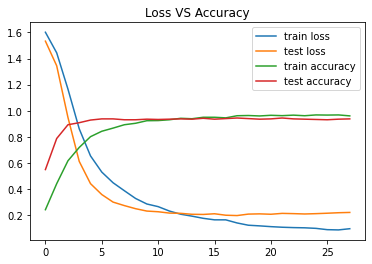

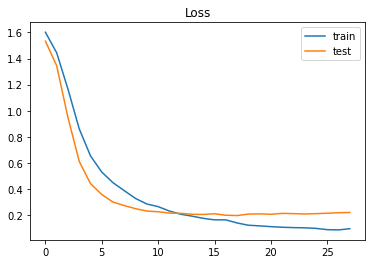

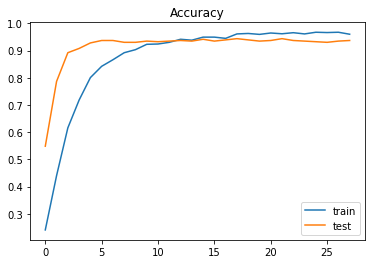

(None, None, None)

In [ ]:
plot_graphs(hist1),loss_graph(hist1),acc_graph(hist1)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 93.71%
Precision: 0.94
Recall: 0.94
F1 score: 0.94


{'accuracy': 0.94, 'f1': 0.94, 'precision': 0.94, 'recall': 0.94}

In [ ]:
# Testing Random Text and Predicted Classes :

original_text=raw_df['Text']
text = original_text[18]
new_text = [clean_text(text)]
print(text)
print(new_text)
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')

japanes bank battl end japan sumitomo mitsui financi withdrawn takeov offer rival bank ufj hold enabl latter merg mitsubishi tokyo sumitomo boss told counterpart ufj decis friday clear way conclud trillion yen bn deal mitsubishi deal would creat world biggest bank asset trillion yen trillion sumitomo eit end high profil fight japanes bank histori ufj hold japan fourthlargest bank centr fierc bid battl last year sumitomo japan thirdlargest bank tabl higher offer ufj rival valu compani bn howev ufj manag known prefer offer mitsubishi tokyo financi group mtfg japan secondlargest bank concern also rais sumitomo abil absorb ufj former admit defeat believ market investor accept ufjmtfg merger sumitomo said statement given ongo integr ufj mtfg oper persist propos may best interest sharehold ufj mitsubishi takeov ufj japan largestev takeov deal still approv sharehold two firm howev epect formal sumitomo may turn attent deepen tie daiwa secur anoth japanes financi firm two set merg ventur capit

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/150
56/56 [==============================] - 1s 10ms/step - loss: 1.6238 - accuracy: 0.1835 - val_loss: 1.6037 - val_accuracy: 0.2045

Epoch 00001: val_accuracy improved from -inf to 0.20449, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 0s 7ms/step - loss: 1.6107 - accuracy: 0.2248 - val_loss: 1.6010 - val_accuracy: 0.2202

Epoch 00002: val_accuracy improved from 0.20449 to 0.22022, saving model to weights_best_cnn.hdf5
Epoch 3/150
56/56 [==============================] - 0s 8ms/step - loss: 1.6030 - accuracy: 0.2356 - val_loss: 1.5980 - val_accuracy: 0.2270

Epoch 00003: val_accuracy improved from 0.22022 to 0.22697, saving model to weights_best_cnn.hdf5
Epoch 4/150
56/56 [==============================] - 0s 7ms/step - loss: 1.5945 - accuracy: 0.2692 - val_loss: 1.5948 - val_accuracy: 0.3011

Epoch 00004: val_accuracy improved from 0.22697 to 0.30112, saving model to weights_best_cnn.hdf5
Epoch 5/150
56/56 [=======================

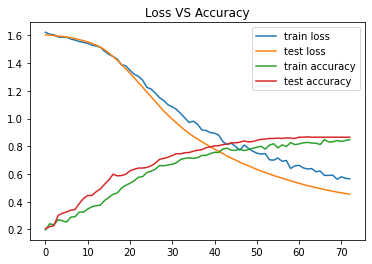

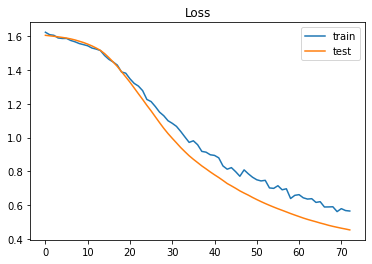

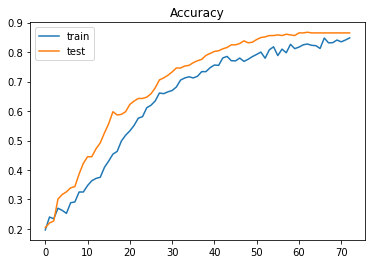

(None, None, None)

In [ ]:

# With AdaGrad
tf.keras.backend.clear_session()
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model2.add(Conv1D(48, 5, activation='relu', padding='valid'))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dropout(0.5))

model2.add(Dense(5, activation='softmax'))

optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
    
)
model2.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model2.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t2 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t2)
hist2=history


plot_graphs(hist2),loss_graph(hist2),acc_graph(hist2)


In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model2.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 86.52%
Precision: 0.87
Recall: 0.87
F1 score: 0.87


{'accuracy': 0.87, 'f1': 0.87, 'precision': 0.87, 'recall': 0.87}

Epoch 1/150
56/56 [==============================] - 1s 10ms/step - loss: 1.6333 - accuracy: 0.2053 - val_loss: 1.6071 - val_accuracy: 0.2112

Epoch 00001: val_accuracy improved from -inf to 0.21124, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 0s 8ms/step - loss: 1.6089 - accuracy: 0.2187 - val_loss: 1.6003 - val_accuracy: 0.2494

Epoch 00002: val_accuracy improved from 0.21124 to 0.24944, saving model to weights_best_cnn.hdf5
Epoch 3/150
56/56 [==============================] - 0s 8ms/step - loss: 1.6075 - accuracy: 0.2387 - val_loss: 1.5964 - val_accuracy: 0.2787

Epoch 00003: val_accuracy improved from 0.24944 to 0.27865, saving model to weights_best_cnn.hdf5
Epoch 4/150
56/56 [==============================] - 0s 8ms/step - loss: 1.6001 - accuracy: 0.2214 - val_loss: 1.5921 - val_accuracy: 0.2876

Epoch 00004: val_accuracy improved from 0.27865 to 0.28764, saving model to weights_best_cnn.hdf5
Epoch 5/150
56/56 [=======================

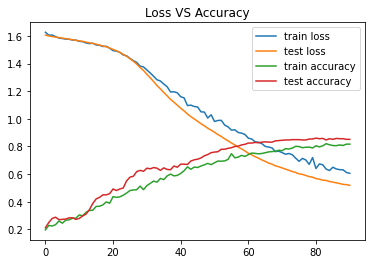

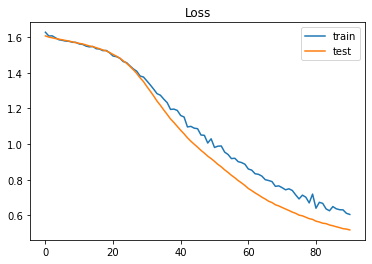

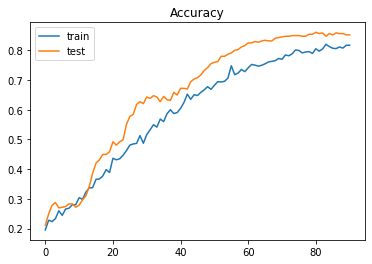

(None, None, None)

In [ ]:

# With SGD
tf.keras.backend.clear_session()
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model3.add(Conv1D(48, 5, activation='relu', padding='valid'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dropout(0.5))

model3.add(Dense(5, activation='softmax'))

optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model3.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model3.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t3 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t3)
hist3=history


plot_graphs(hist3),loss_graph(hist3),acc_graph(hist3)


In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model3.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 85.17%
Precision: 0.85
Recall: 0.85
F1 score: 0.85


{'accuracy': 0.85, 'f1': 0.85, 'precision': 0.85, 'recall': 0.85}

Epoch 1/150
56/56 [==============================] - 2s 25ms/step - loss: 1.3377 - accuracy: 0.4129 - val_loss: 0.3338 - val_accuracy: 0.9034

Epoch 00001: val_accuracy improved from -inf to 0.90337, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 1s 23ms/step - loss: 0.5236 - accuracy: 0.8233 - val_loss: 0.2194 - val_accuracy: 0.9393

Epoch 00002: val_accuracy improved from 0.90337 to 0.93933, saving model to weights_best_cnn.hdf5
Epoch 3/150
56/56 [==============================] - 1s 23ms/step - loss: 0.3623 - accuracy: 0.8695 - val_loss: 0.2132 - val_accuracy: 0.9461

Epoch 00003: val_accuracy improved from 0.93933 to 0.94607, saving model to weights_best_cnn.hdf5
Epoch 4/150
56/56 [==============================] - 1s 23ms/step - loss: 0.2741 - accuracy: 0.9073 - val_loss: 0.2344 - val_accuracy: 0.9281

Epoch 00004: val_accuracy did not improve from 0.94607
Epoch 5/150
56/56 [==============================] - 1s 22ms/step - loss: 0.2068 -

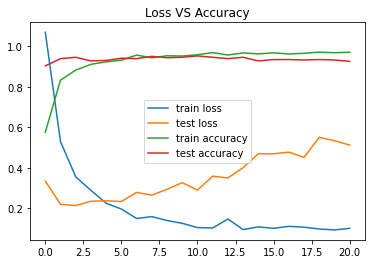

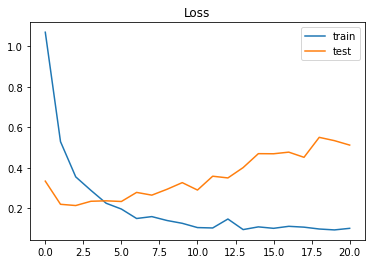

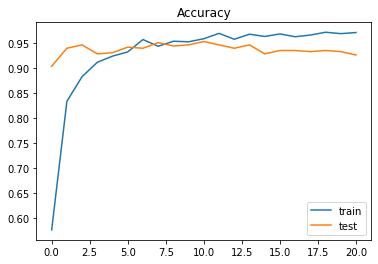

(None, None, None)

In [ ]:

# With RMSPROP
tf.keras.backend.clear_session()
model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model4.add(Conv1D(48, 5, activation='relu', padding='valid'))
model4.add(GlobalMaxPooling1D())
model4.add(Dropout(0.5))

model4.add(Flatten())
model4.add(Dropout(0.5))

model4.add(Dense(5, activation='softmax'))

optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
    
)
model4.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model4.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t4 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t4)
hist4=history


plot_graphs(hist4),loss_graph(hist4),acc_graph(hist4)


In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model4.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 92.58%
Precision: 0.93
Recall: 0.93
F1 score: 0.93


{'accuracy': 0.93, 'f1': 0.93, 'precision': 0.93, 'recall': 0.93}

Epoch 1/150
56/56 [==============================] - 1s 11ms/step - loss: 1.6306 - accuracy: 0.2224 - val_loss: 1.6162 - val_accuracy: 0.1843

Epoch 00001: val_accuracy improved from -inf to 0.18427, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 0s 9ms/step - loss: 1.6365 - accuracy: 0.1818 - val_loss: 1.6154 - val_accuracy: 0.1843

Epoch 00002: val_accuracy did not improve from 0.18427
Epoch 3/150
56/56 [==============================] - 0s 9ms/step - loss: 1.6332 - accuracy: 0.1976 - val_loss: 1.6147 - val_accuracy: 0.1843

Epoch 00003: val_accuracy did not improve from 0.18427
Epoch 4/150
56/56 [==============================] - 0s 9ms/step - loss: 1.6304 - accuracy: 0.2014 - val_loss: 1.6140 - val_accuracy: 0.1843

Epoch 00004: val_accuracy did not improve from 0.18427
Epoch 5/150
56/56 [==============================] - 0s 8ms/step - loss: 1.6266 - accuracy: 0.2173 - val_loss: 1.6134 - val_accuracy: 0.1865

Epoch 00005: val_accuracy imp

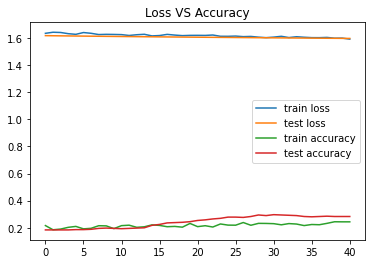

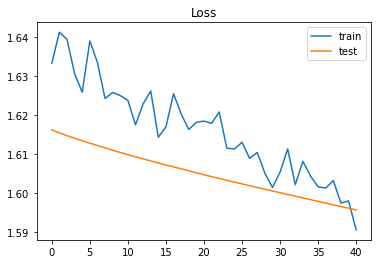

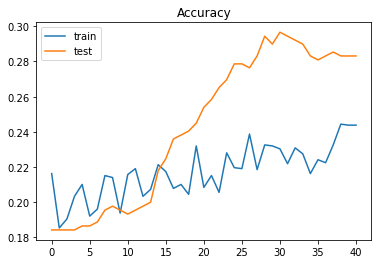

(None, None, None)

In [ ]:

# With Adadelta
tf.keras.backend.clear_session()

model5 = Sequential()
model5.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model5.add(Conv1D(48, 5, activation='relu', padding='valid'))
model5.add(GlobalMaxPooling1D())
model5.add(Dropout(0.5))

model5.add(Flatten())
model5.add(Dropout(0.5))

model5.add(Dense(5, activation='softmax'))

optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
)
model5.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model5.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t5 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t5)
hist5=history


plot_graphs(hist5),loss_graph(hist5),acc_graph(hist5)


In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model5.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 28.31%
Precision: 0.28
Recall: 0.28
F1 score: 0.28


{'accuracy': 0.28, 'f1': 0.28, 'precision': 0.28, 'recall': 0.28}

2.Using LSTMs :

In [ ]:

tf.keras.backend.clear_session()
model6 = Sequential()

model6.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model6.add(Dropout(0.5))
model6.add(LSTM(embedding_dim))
model6.add(Dense(5, activation='softmax'))

model6.summary()

model6.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model6.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t6 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t6)
hist6=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 6s 80ms/step - loss: 1.5571 - accuracy: 0.2796 - val_loss: 1.4121 - val_accuracy: 0.3685

Epoch 00001: val_accuracy improved from -inf to 0.36854, saving model to weights_best_lstms.hdf5
Epoc

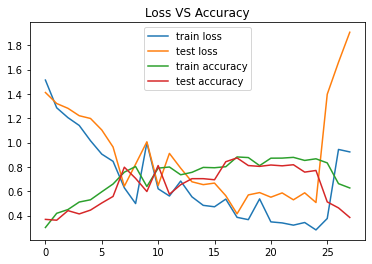

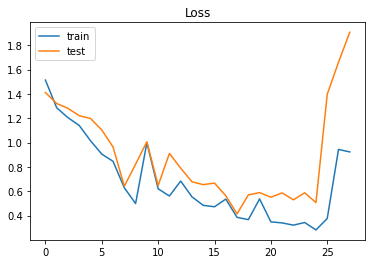

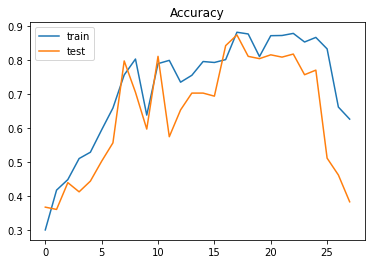

(None, None, None)

In [ ]:
plot_graphs(hist6),loss_graph(hist6),acc_graph(hist6)

In [ ]:
predicted = model6.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 38.43%
Precision: 0.38
Recall: 0.38
F1 score: 0.38


{'accuracy': 0.38, 'f1': 0.38, 'precision': 0.38, 'recall': 0.38}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 3s 26ms/step - loss: 1.6013 - accuracy: 0.2264 - val_loss: 1.5891 - val_accuracy: 0.2090

Epoch 00001: val_accuracy improved from -inf to 0.20899, saving model to weights_best_lstms.hdf5
Epoc

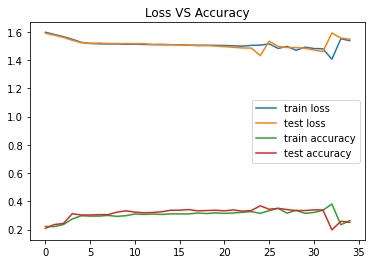

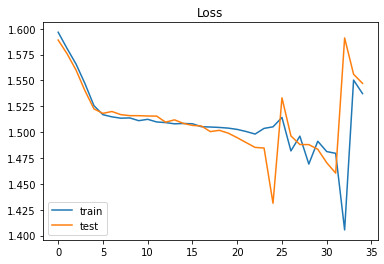

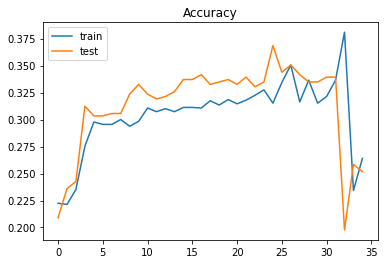

(None, None, None)

In [ ]:

#With Adagrad :
tf.keras.backend.clear_session()
model7 = Sequential()

model7.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model7.add(Dropout(0.5))
model7.add(LSTM(embedding_dim))
model7.add(Dense(5, activation='softmax'))

model7.summary()
optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
)
model7.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model7.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t7 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t7)
hist7=history

plot_graphs(hist7),loss_graph(hist7),acc_graph(hist7)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model7.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 25.17%
Precision: 0.25
Recall: 0.25
F1 score: 0.25


{'accuracy': 0.25, 'f1': 0.25, 'precision': 0.25, 'recall': 0.25}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 2s 22ms/step - loss: 1.6060 - accuracy: 0.2089 - val_loss: 1.5958 - val_accuracy: 0.2292

Epoch 00001: val_accuracy improved from -inf to 0.22921, saving model to weights_best_lstms.hdf5
Epoc

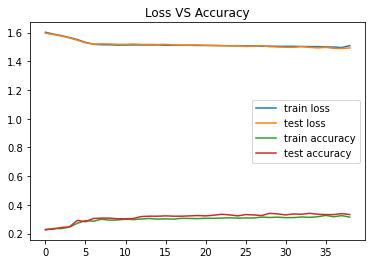

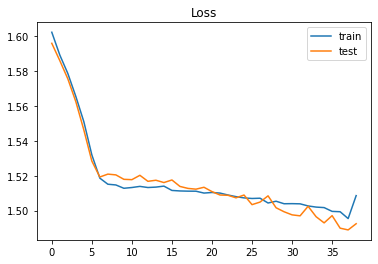

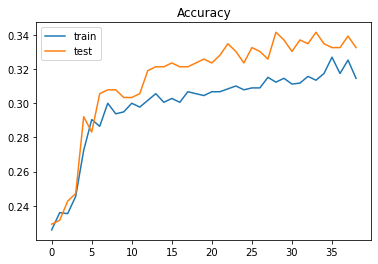

(None, None, None)

In [ ]:

#With SGD :
tf.keras.backend.clear_session()
model8 = Sequential()

model8.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model8.add(Dropout(0.5))
model8.add(LSTM(embedding_dim))
model8.add(Dense(5, activation='softmax'))

model8.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model8.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model8.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t8 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t8)
hist8=history

plot_graphs(hist8),loss_graph(hist8),acc_graph(hist8)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model8.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 33.26%
Precision: 0.33
Recall: 0.33
F1 score: 0.33


{'accuracy': 0.33, 'f1': 0.33, 'precision': 0.33, 'recall': 0.33}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 4s 44ms/step - loss: 1.6547 - accuracy: 0.2654 - val_loss: 1.5160 - val_accuracy: 0.3034

Epoch 00001: val_accuracy improved from -inf to 0.30337, saving model to weights_best_lstms.hdf5
Epoc

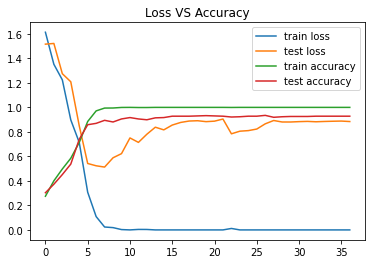

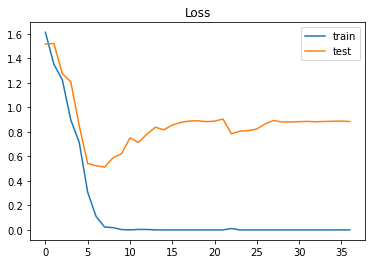

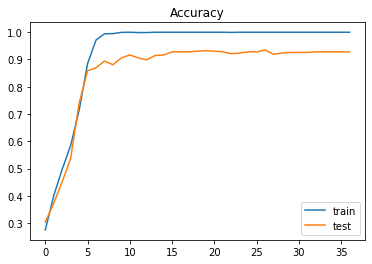

(None, None, None)

In [ ]:

#With RMSProp :
tf.keras.backend.clear_session()
model9 = Sequential()

model9.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model9.add(Dropout(0.5))
model9.add(LSTM(embedding_dim))
model9.add(Dense(5, activation='softmax'))

model9.summary()
optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
)
model9.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model9.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t9 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t9)
hist9=history

plot_graphs(hist9),loss_graph(hist9),acc_graph(hist9)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model9.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 92.81%
Precision: 0.93
Recall: 0.93
F1 score: 0.93


{'accuracy': 0.93, 'f1': 0.93, 'precision': 0.93, 'recall': 0.93}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 3s 24ms/step - loss: 1.6105 - accuracy: 0.1763 - val_loss: 1.6081 - val_accuracy: 0.2764

Epoch 00001: val_accuracy improved from -inf to 0.27640, saving model to weights_best_lstms.hdf5
Epoc

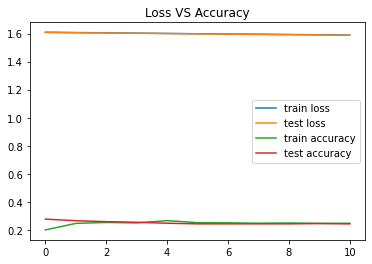

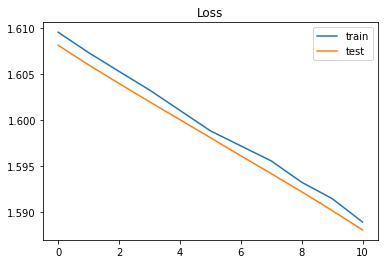

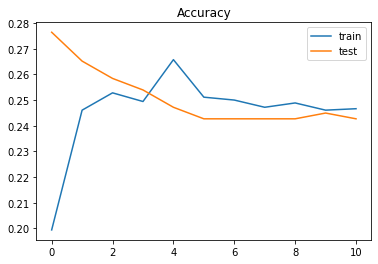

(None, None, None)

In [ ]:

#With Adadelta :
tf.keras.backend.clear_session()
model10 = Sequential()

model10.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model10.add(Dropout(0.5))
model10.add(LSTM(embedding_dim))
model10.add(Dense(5, activation='softmax'))

model10.summary()
optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01)
model10.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model10.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t10 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t10)
hist10=history

plot_graphs(hist10),loss_graph(hist10),acc_graph(hist10)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model10.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 24.27%
Precision: 0.24
Recall: 0.24
F1 score: 0.24


{'accuracy': 0.24, 'f1': 0.24, 'precision': 0.24, 'recall': 0.24}

3.Using Bi-Directional LSTMs :

In [ ]:

tf.keras.backend.clear_session()
model11 = Sequential()

model11.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model11.add(Dropout(0.5))
model11.add(Bidirectional(LSTM(embedding_dim)))
model11.add(Dense(5, activation='softmax'))

model11.summary()

model11.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model11.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t11 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t11)
hist11=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 8s 102ms/step - loss: 1.5006 - accuracy: 0.3571 - val_loss: 0.9670 - val_accuracy: 0.4899

Epoch 00001: val_accuracy improved from -inf to 0.48989, saving model to weights_best_bi_lstms.hdf5


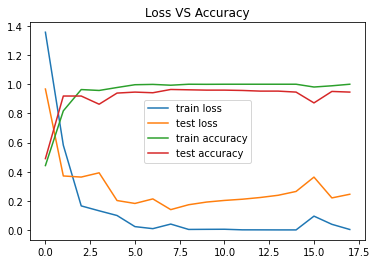

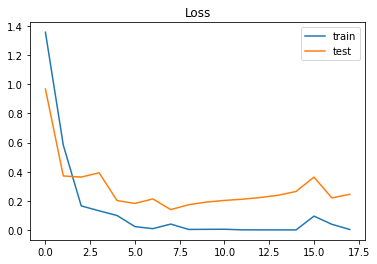

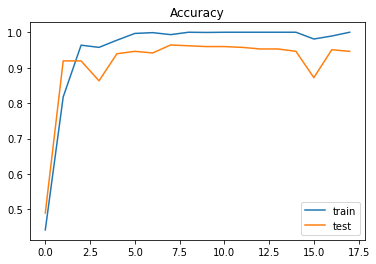

(None, None, None)

In [ ]:
plot_graphs(hist11),loss_graph(hist11),acc_graph(hist11)

In [ ]:
predicted = model11.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 94.61%
Precision: 0.95
Recall: 0.95
F1 score: 0.95


{'accuracy': 0.95, 'f1': 0.95, 'precision': 0.95, 'recall': 0.95}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 4s 37ms/step - loss: 1.6072 - accuracy: 0.2015 - val_loss: 1.5961 - val_accuracy: 0.2202

Epoch 00001: val_accuracy improved from -inf to 0.22022, saving model to weights_best_bi_lstms.hdf5
E

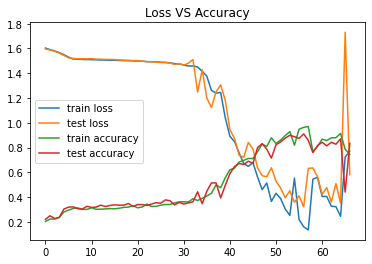

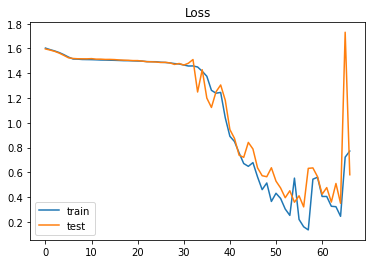

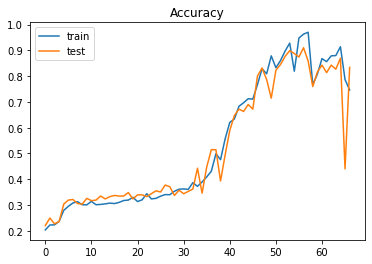

(None, None, None)

In [ ]:
#with Adagrad
tf.keras.backend.clear_session()
model12 = Sequential()

model12.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model12.add(Dropout(0.5))
model12.add(Bidirectional(LSTM(embedding_dim)))
model12.add(Dense(5, activation='softmax'))

model12.summary()
optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
)
model12.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model12.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t12 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t12)
hist12=history

plot_graphs(hist12),loss_graph(hist12),acc_graph(hist12)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model12.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 83.37%
Precision: 0.83
Recall: 0.83
F1 score: 0.83


{'accuracy': 0.83, 'f1': 0.83, 'precision': 0.83, 'recall': 0.83}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 5s 37ms/step - loss: 1.6017 - accuracy: 0.2409 - val_loss: 1.5953 - val_accuracy: 0.2427

Epoch 00001: val_accuracy improved from -inf to 0.24270, saving model to weights_best_bi_lstms.hdf5
E

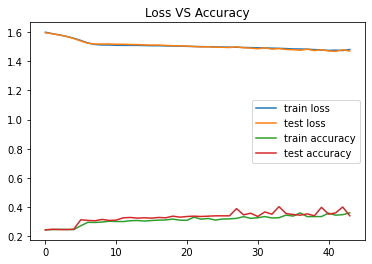

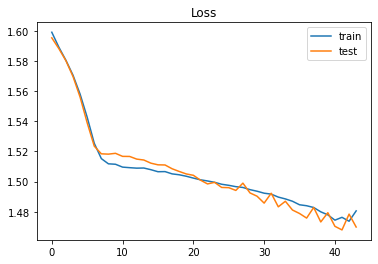

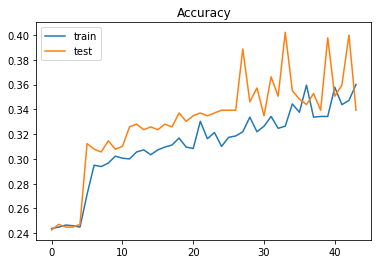

(None, None, None)

In [ ]:
#with SGD
tf.keras.backend.clear_session()
model13 = Sequential()

model13.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model13.add(Dropout(0.5))
model13.add(Bidirectional(LSTM(embedding_dim)))
model13.add(Dense(5, activation='softmax'))

model13.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model13.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model13.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t13 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t13)
hist13=history

plot_graphs(hist13),loss_graph(hist13),acc_graph(hist13)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model13.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 33.93%
Precision: 0.34
Recall: 0.34
F1 score: 0.34


{'accuracy': 0.34, 'f1': 0.34, 'precision': 0.34, 'recall': 0.34}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 5s 55ms/step - loss: 1.8140 - accuracy: 0.2731 - val_loss: 0.9812 - val_accuracy: 0.6449

Epoch 00001: val_accuracy improved from -inf to 0.64494, saving model to weights_best_bi_lstms.hdf5
E

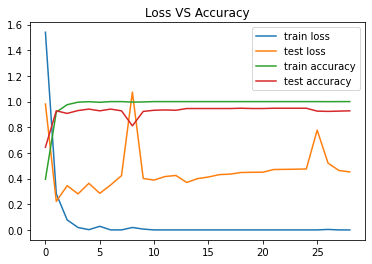

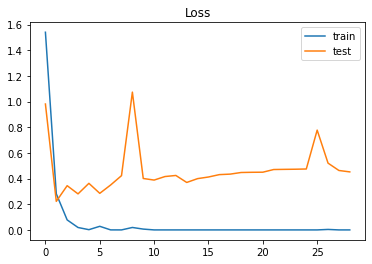

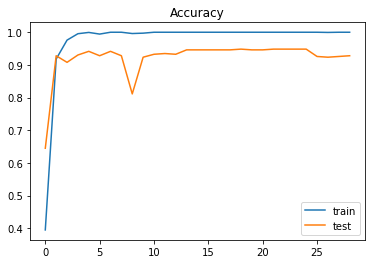

(None, None, None)

In [ ]:
#with RMSProp
tf.keras.backend.clear_session()
model14 = Sequential()

model14.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model14.add(Dropout(0.5))
model14.add(Bidirectional(LSTM(embedding_dim)))
model14.add(Dense(5, activation='softmax'))

model14.summary()
optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
)
model14.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model14.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t14 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t14)
hist14=history

plot_graphs(hist14),loss_graph(hist14),acc_graph(hist14)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model14.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 92.81%
Precision: 0.93
Recall: 0.93
F1 score: 0.93


{'accuracy': 0.93, 'f1': 0.93, 'precision': 0.93, 'recall': 0.93}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 4s 39ms/step - loss: 1.6104 - accuracy: 0.1776 - val_loss: 1.6092 - val_accuracy: 0.2449

Epoch 00001: val_accuracy improved from -inf to 0.24494, saving model to weights_best_bi_lstms.hdf5
E

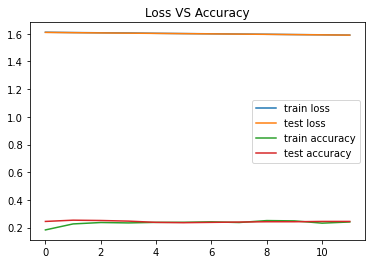

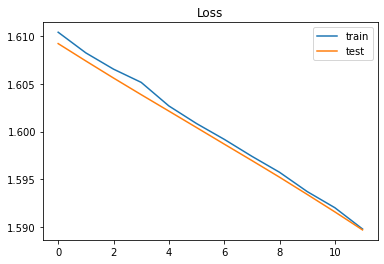

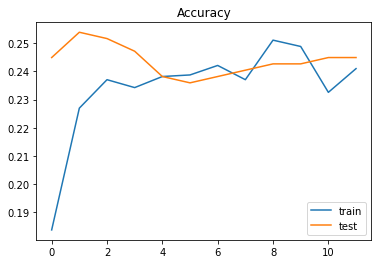

(None, None, None)

In [ ]:
#with Adadelta
tf.keras.backend.clear_session()
model15 = Sequential()

model15.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model15.add(Dropout(0.5))
model15.add(Bidirectional(LSTM(embedding_dim)))
model15.add(Dense(5, activation='softmax'))

model15.summary()
optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
)
model15.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model15.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t15 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t15)
hist15=history

plot_graphs(hist15),loss_graph(hist15),acc_graph(hist15)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model15.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 24.49%
Precision: 0.24
Recall: 0.24
F1 score: 0.24


{'accuracy': 0.24, 'f1': 0.24, 'precision': 0.24, 'recall': 0.24}

4.Using CNN1D + LSTMs :

In [ ]:

tf.keras.backend.clear_session()
model16 = Sequential()

model16.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model16.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model16.add(MaxPooling1D(pool_size=2))
model16.add(LSTM(embedding_dim))
model16.add(Dense(5, activation='softmax'))

model16.summary()

model16.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model16.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t16 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t16)
hist16=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 7s 85ms/step - loss: 1.5338 - accuracy: 0.2945 - val_loss: 

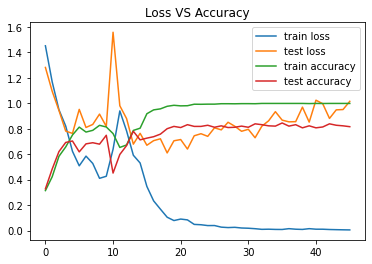

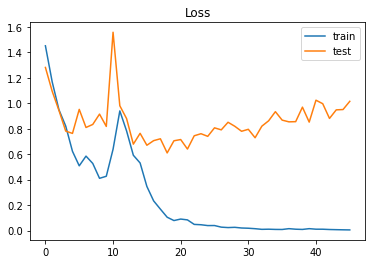

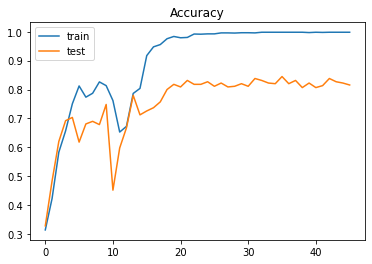

(None, None, None)

In [ ]:
plot_graphs(hist16),loss_graph(hist16),acc_graph(hist16)

In [ ]:
predicted = model16.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 81.57%
Precision: 0.82
Recall: 0.82
F1 score: 0.82


{'accuracy': 0.82, 'f1': 0.82, 'precision': 0.82, 'recall': 0.82}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 2s 19ms/step - loss: 1.6033 - accuracy: 0.1895 - val_loss: 

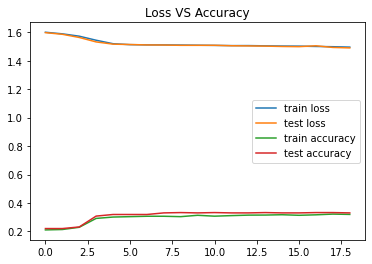

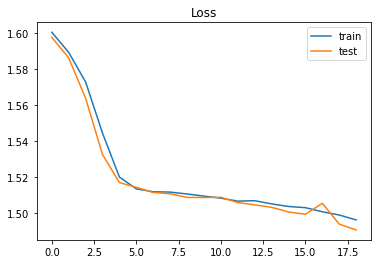

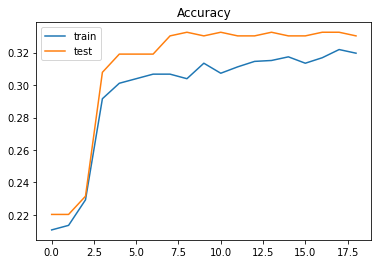

(None, None, None)

In [ ]:
#With AdaGrad
tf.keras.backend.clear_session()
model17 = Sequential()

model17.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model17.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model17.add(MaxPooling1D(pool_size=2))
model17.add(LSTM(embedding_dim))
model17.add(Dense(5, activation='softmax'))

model17.summary()
optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
)
model17.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model17.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t17 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t17)
hist17=history

plot_graphs(hist17),loss_graph(hist17),acc_graph(hist17)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model17.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 33.03%
Precision: 0.33
Recall: 0.33
F1 score: 0.33


{'accuracy': 0.33, 'f1': 0.33, 'precision': 0.33, 'recall': 0.33}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 3s 20ms/step - loss: 1.6084 - accuracy: 0.2046 - val_loss: 

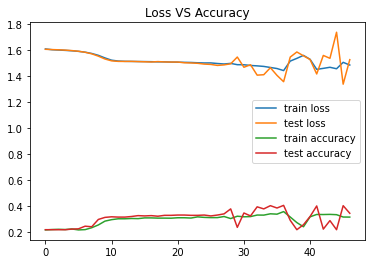

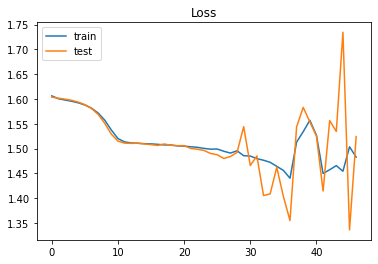

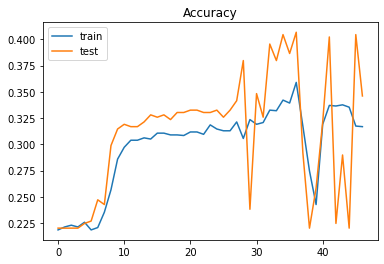

(None, None, None)

In [ ]:
#With SGD
tf.keras.backend.clear_session()
model18 = Sequential()

model18.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model18.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model18.add(MaxPooling1D(pool_size=2))
model18.add(LSTM(embedding_dim))
model18.add(Dense(5, activation='softmax'))

model18.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model18.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model18.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t18 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t18)
hist18=history

plot_graphs(hist18),loss_graph(hist18),acc_graph(hist18)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model18.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 34.61%
Precision: 0.35
Recall: 0.35
F1 score: 0.35


{'accuracy': 0.35, 'f1': 0.35, 'precision': 0.35, 'recall': 0.35}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 4s 39ms/step - loss: 1.7264 - accuracy: 0.2802 - val_loss: 

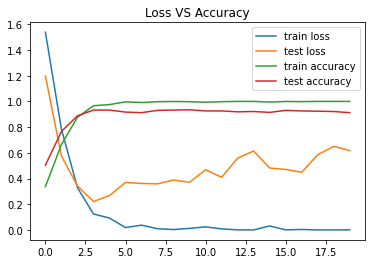

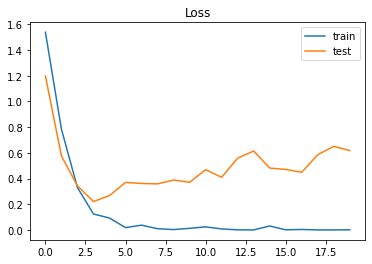

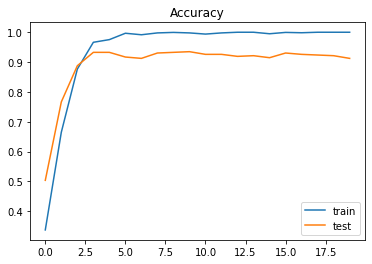

(None, None, None)

In [ ]:
#With RMSprop
tf.keras.backend.clear_session()
model19 = Sequential()

model19.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model19.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model19.add(MaxPooling1D(pool_size=2))
model19.add(LSTM(embedding_dim))
model19.add(Dense(5, activation='softmax'))

model19.summary()
optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
)
model19.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model19.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t19 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t19)
hist19=history

plot_graphs(hist19),loss_graph(hist19),acc_graph(hist19)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model19.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 91.24%
Precision: 0.91
Recall: 0.91
F1 score: 0.91


{'accuracy': 0.91, 'f1': 0.91, 'precision': 0.91, 'recall': 0.91}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 10s 141ms/step - loss: 1.6082 - accuracy: 0.1924 - val_loss

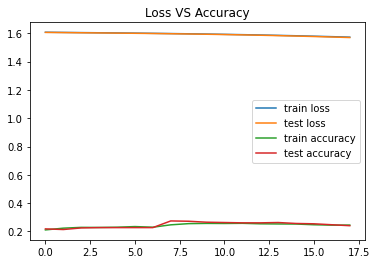

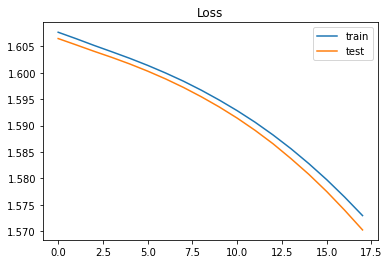

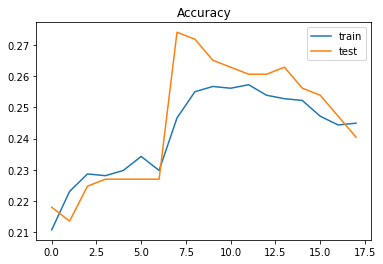

(None, None, None)

In [ ]:
#With AdaDelta
tf.keras.backend.clear_session()
model20 = Sequential()

model20.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model20.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model20.add(MaxPooling1D(pool_size=2))
model20.add(LSTM(embedding_dim))
model20.add(Dense(5, activation='softmax'))

model20.summary()
optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
)
model20.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model20.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t20 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t20)
hist20=history

plot_graphs(hist20),loss_graph(hist20),acc_graph(hist20)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model20.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 24.04%
Precision: 0.24
Recall: 0.24
F1 score: 0.24


{'accuracy': 0.24, 'f1': 0.24, 'precision': 0.24, 'recall': 0.24}

5.Using Bi_LSTMs + CNN1D :

In [ ]:

tf.keras.backend.clear_session()
model21 = Sequential()

model21.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model21.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model21.add(MaxPooling1D(pool_size=2))
model21.add(Bidirectional(LSTM(embedding_dim)))
model21.add(Dense(5, activation='softmax'))

model21.summary()

model21.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model21.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t21 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t21)
hist21=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 19s 273ms/step - loss: 1.5117 - accuracy: 0.3302 - val_loss

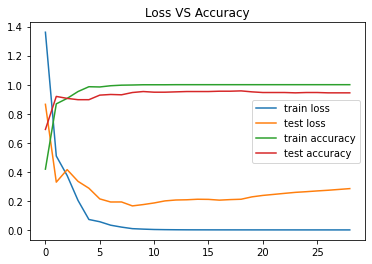

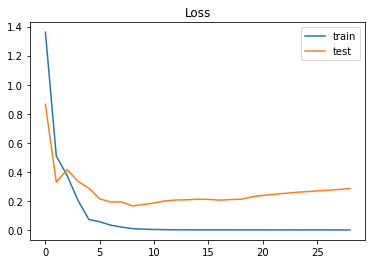

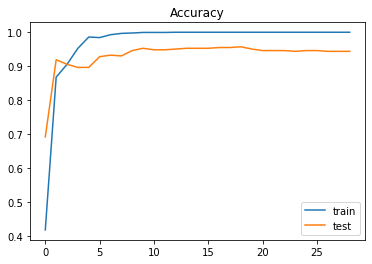

(None, None, None)

In [ ]:
plot_graphs(hist21),loss_graph(hist21),acc_graph(hist21)

In [ ]:
predicted = model21.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 94.38%
Precision: 0.94
Recall: 0.94
F1 score: 0.94


{'accuracy': 0.94, 'f1': 0.94, 'precision': 0.94, 'recall': 0.94}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 4s 29ms/step - loss: 1.6060 - accuracy: 0.2049 - val_loss: 

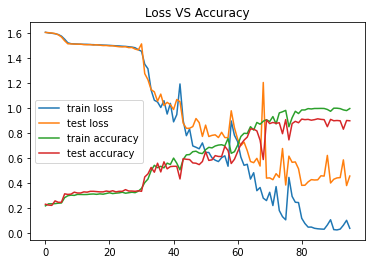

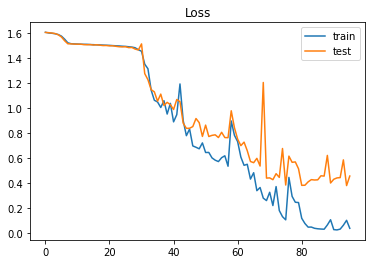

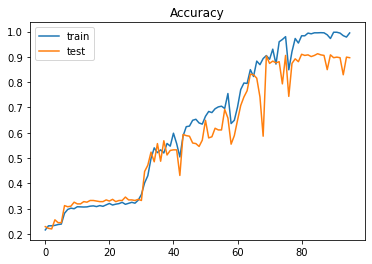

(None, None, None)

In [ ]:
#With AdaGrad
tf.keras.backend.clear_session()
model22 = Sequential()

model22.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model22.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model22.add(MaxPooling1D(pool_size=2))
model22.add(Bidirectional(LSTM(embedding_dim)))
model22.add(Dense(5, activation='softmax'))

model22.summary()
optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
)
model22.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model22.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t22 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t22)
hist22=history

plot_graphs(hist22),loss_graph(hist22),acc_graph(hist22)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model22.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 89.66%
Precision: 0.90
Recall: 0.90
F1 score: 0.90


{'accuracy': 0.9, 'f1': 0.9, 'precision': 0.9, 'recall': 0.9}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 4s 30ms/step - loss: 1.6083 - accuracy: 0.2035 - val_loss: 

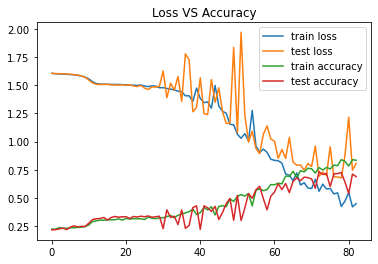

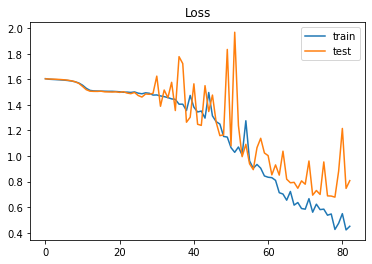

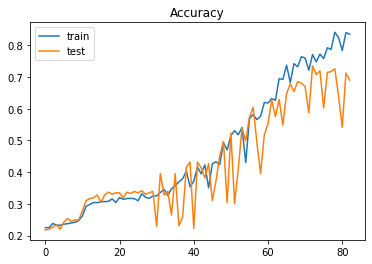

(None, None, None)

In [ ]:
#With SGD
tf.keras.backend.clear_session()
model23 = Sequential()

model23.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model23.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model23.add(MaxPooling1D(pool_size=2))
model23.add(Bidirectional(LSTM(embedding_dim)))
model23.add(Dense(5, activation='softmax'))

model23.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model23.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model23.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t23 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t23)
hist23=history

plot_graphs(hist23),loss_graph(hist23),acc_graph(hist23)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model23.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 68.99%
Precision: 0.69
Recall: 0.69
F1 score: 0.69


{'accuracy': 0.69, 'f1': 0.69, 'precision': 0.69, 'recall': 0.69}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 5s 51ms/step - loss: 1.9106 - accuracy: 0.2570 - val_loss: 

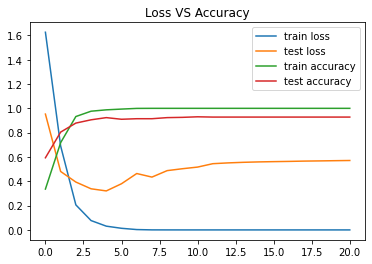

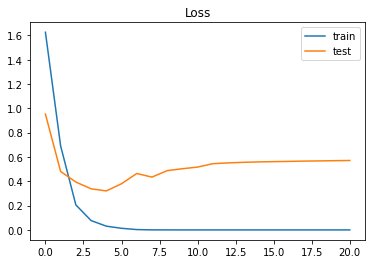

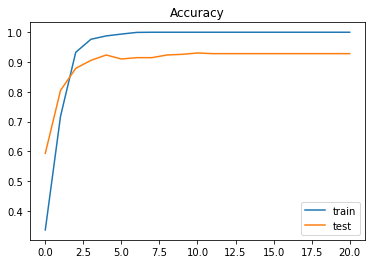

(None, None, None)

In [ ]:
#With RMSProp
tf.keras.backend.clear_session()
model24 = Sequential()

model24.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model24.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model24.add(MaxPooling1D(pool_size=2))
model24.add(Bidirectional(LSTM(embedding_dim)))
model24.add(Dense(5, activation='softmax'))

model24.summary()
optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
)
model24.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model24.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t24 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t24)
hist24=history

plot_graphs(hist24),loss_graph(hist24),acc_graph(hist24)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model24.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 92.81%
Precision: 0.93
Recall: 0.93
F1 score: 0.93


{'accuracy': 0.93, 'f1': 0.93, 'precision': 0.93, 'recall': 0.93}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 5s 31ms/step - loss: 1.6092 - accuracy: 0.1973 - val_loss: 

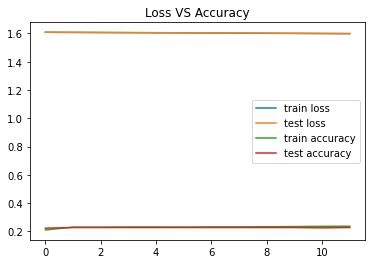

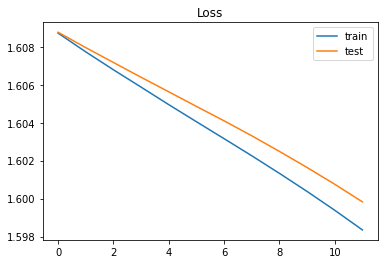

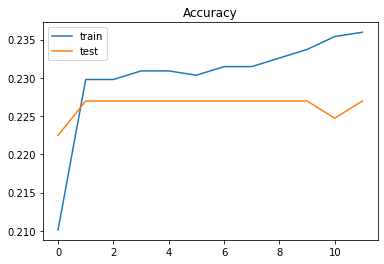

(None, None, None)

In [ ]:
#With Adadelta
tf.keras.backend.clear_session()
model25 = Sequential()

model25.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model25.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model25.add(MaxPooling1D(pool_size=2))
model25.add(Bidirectional(LSTM(embedding_dim)))
model25.add(Dense(5, activation='softmax'))

model25.summary()
optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
)
model25.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model25.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t25 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t25)
hist25=history

plot_graphs(hist25),loss_graph(hist25),acc_graph(hist25)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model25.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 22.70%
Precision: 0.23
Recall: 0.23
F1 score: 0.23


{'accuracy': 0.23, 'f1': 0.23, 'precision': 0.23, 'recall': 0.23}

## Overall Evaluation of all Models

In [ ]:
print("Final Performance Of All Models : \n")
print("Model 1 - CNN-1D \n")





print("With Adam : \n")
mod1=model_eval(model,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod2=model_eval(model2,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod3=model_eval(model3,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod4=model_eval(model4,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod5=model_eval(model5,train_padded,training_labels,validation_padded,validation_labels)

print("Model 2 - LSTM \n")

print("With Adam : \n")
mod6=model_eval(model6,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod7=model_eval(model7,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod8=model_eval(model8,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod9=model_eval(model9,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod10=model_eval(model10,train_padded,training_labels,validation_padded,validation_labels)


print("Model 3 - BiDirectional LSTM \n")
mod11=model_eval(model11,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod12=model_eval(model12,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod13=model_eval(model13,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod14=model_eval(model14,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod15=model_eval(model15,train_padded,training_labels,validation_padded,validation_labels)

print("Model 4 - CNN 1-D + LSTM \n")

print("With Adam : \n")
mod16=model_eval(model16,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod17=model_eval(model17,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod18=model_eval(model18,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod19=model_eval(model19,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod20=model_eval(model20,train_padded,training_labels,validation_padded,validation_labels)

print("Model 5 - CNN 1-D + Bi Directional LSTM \n")

print("With Adam : \n")
mod21=model_eval(model21,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod22=model_eval(model22,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod23=model_eval(model23,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod24=model_eval(model24,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod25=model_eval(model25,train_padded,training_labels,validation_padded,validation_labels)

Final Performance Of All Models : 

Model 1 - CNN-1D 

With Adam : 



Model Loss on training data  0.001023116521537304
Model Accuracy on training data:  1.0
Model Loss on validation data 0.2194020003080368
Model Accuracy on validation data:  0.9370786547660828


With AdaGrad : 



Model Loss on training data  0.313386470079422
Model Accuracy on training data:  0.9421348571777344
Model Loss on validation data 0.4540248215198517
Model Accuracy on validation data:  0.8651685118675232


With SGD : 



Model Loss on training data  0.3709962069988251
Model Accuracy on training data:  0.9151685237884521
Model Loss on validation data 0.5186095237731934
Model Accuracy on validation data:  0.8516854047775269


With RMSProp : 



Model Loss on training data  2.1193507564021274e-05
Model Accuracy on training data:  1.0
Model Loss on validation data 0.512007474899292
Model Accuracy on validation data:  0.9258427023887634


With AdaDelta : 



Model Loss on training data  1.5820285081863403
Model 

In [ ]:


table = PrettyTable()

table.field_names = ['Model [With Optimiser]', 'Accuracy','Time Taken To Train (secs)']

table.add_row(['CNN-1D [Adam]',round(mod1[1][1]*100,2),round(t1,2)])
table.add_row(['CNN-1D [AdaGrad]', round(mod2[1][1]*100,2),round(t2,2)])
table.add_row(['CNN-1D [SGD]', round(mod3[1][1]*100,2),round(t3,2)])
table.add_row(['CNN-1D [RMSProp]', round(mod4[1][1]*100,2),round(t4,2)])
table.add_row(['CNN-1D [AdaDelta]', round(mod5[1][1]*100,2),round(t5,2)])

table.add_row(['LSTM [Adam]',round(mod6[1][1]*100,2),round(t6,2)])
table.add_row(['LSTM [AdaGrad]', round(mod7[1][1]*100,2),round(t7,2)])
table.add_row(['LSTM [SGD]', round(mod8[1][1]*100,2),round(t8,2)])
table.add_row(['LSTM [RMSProp]', round(mod9[1][1]*100,2),round(t9,2)])
table.add_row(['LSTM [AdaDelta]', round(mod10[1][1]*100,2),round(t10,2)])



table.add_row(['Bidirectional LSTM [Adam]',round(mod11[1][1]*100,2),round(t11,2)])
table.add_row(['Bidirectional LSTM [AdaGrad]', round(mod12[1][1]*100,2),round(t12,2)])
table.add_row(['Bidirectional LSTM [SGD]', round(mod13[1][1]*100,2),round(t13,2)])
table.add_row(['Bidirectional LSTM [RMSProp]', round(mod14[1][1]*100,2),round(t14,2)])
table.add_row(['Bidirectional LSTM [AdaDelta]', round(mod15[1][1]*100,2),round(t15,2)])



table.add_row([' CNN-1D + LSTM  [Adam]',round(mod16[1][1]*100,2),round(t16,2)])
table.add_row([' CNN-1D + LSTM  [AdaGrad]', round(mod17[1][1]*100,2),round(t17,2)])
table.add_row([' CNN-1D + LSTM  [SGD]', round(mod18[1][1]*100,2),round(t18,2)])
table.add_row([' CNN-1D + LSTM  [RMSProp]', round(mod19[1][1]*100,2),round(t19,2)])
table.add_row([' CNN-1D + LSTM  [AdaDelta]', round(mod20[1][1]*100,2),round(t20,2)])



table.add_row([' CNN-1D + Bidirectional LSTM  [Adam]',round(mod21[1][1]*100,2),round(t21,2)])
table.add_row([' CNN-1D + Bidirectional LSTM  [AdaGrad]', round(mod22[1][1]*100,2),round(t22,2)])
table.add_row([' CNN-1D + Bidirectional LSTM  [SGD]', round(mod23[1][1]*100,2),round(t23,2)])
table.add_row([' CNN-1D + Bidirectional LSTM  [RMSProp]', round(mod24[1][1]*100,2),round(t24,2)])
table.add_row([' CNN-1D + Bidirectional LSTM  [AdaDelta]', round(mod25[1][1]*100,2),round(t25,2)])


print(table)

+------------------------------------------+----------+----------------------------+
|          Model [With Optimiser]          | Accuracy | Time Taken To Train (secs) |
+------------------------------------------+----------+----------------------------+
|              CNN-1D [Adam]               |  93.71   |           132.44           |
|             CNN-1D [AdaGrad]             |  86.52   |           42.86            |
|               CNN-1D [SGD]               |  85.17   |           49.21            |
|             CNN-1D [RMSProp]             |  92.58   |           27.58            |
|            CNN-1D [AdaDelta]             |  28.31   |           23.97            |
|               LSTM [Adam]                |  38.43   |           119.48           |
|              LSTM [AdaGrad]              |  25.17   |           32.49            |
|                LSTM [SGD]                |  33.26   |           36.67            |
|              LSTM [RMSProp]              |  92.81   |          

In [84]:
print(table.get_string(sortby='Accuracy',reversesort=True))

+------------------------------------------+----------+----------------------------+
|          Model [With Optimiser]          | Accuracy | Time Taken To Train (secs) |
+------------------------------------------+----------+----------------------------+
|    CNN-1D + Bidirectional LSTM  [Adam]   |  95.28   |           144.17           |
|        Bidirectional LSTM [Adam]         |  94.61   |           91.48            |
|              CNN-1D [Adam]               |  93.71   |           132.44           |
|              LSTM [RMSProp]              |  92.81   |           77.25            |
|       Bidirectional LSTM [RMSProp]       |  92.81   |           75.92            |
|  CNN-1D + Bidirectional LSTM  [RMSProp]  |  92.81   |           48.54            |
|             CNN-1D [RMSProp]             |  92.58   |           27.58            |
|         CNN-1D + LSTM  [RMSProp]         |  91.24   |           38.41            |
|  CNN-1D + Bidirectional LSTM  [AdaGrad]  |  89.66   |          

In [85]:
print(table.get_string(sortby='Time Taken To Train (secs)',reversesort=True))

+------------------------------------------+----------+----------------------------+
|          Model [With Optimiser]          | Accuracy | Time Taken To Train (secs) |
+------------------------------------------+----------+----------------------------+
|           CNN-1D + LSTM  [Adam]          |  81.57   |           181.62           |
|    CNN-1D + Bidirectional LSTM  [Adam]   |  95.28   |           144.17           |
|              CNN-1D [Adam]               |  93.71   |           132.44           |
|               LSTM [Adam]                |  38.43   |           119.48           |
|  CNN-1D + Bidirectional LSTM  [AdaGrad]  |  89.66   |           103.6            |
|       Bidirectional LSTM [AdaGrad]       |  83.37   |           99.64            |
|        Bidirectional LSTM [Adam]         |  94.61   |           91.48            |
|    CNN-1D + Bidirectional LSTM  [SGD]    |  68.99   |           90.17            |
|              LSTM [RMSProp]              |  92.81   |          

#Link For References :

1. https://ruder.io/deep-learning-nlp-best-practices/#:~:text=Optimization%20algorithm%20Adam%20(Kingma%20%26%20Ba,stochastic%20gradient%20descent%20(SGD).
2. https://colah.github.io/posts/2015-08-Understanding-LSTMs/
3. https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
4. https://www.jeansnyman.com/posts/multi-class-text-classification-with-tensorflow/